In [4]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yasminehanafi","key":"88734db413755a53145d660b3cb3d8de"}'}

In [3]:
!rm -rf ~/.kaggle

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign


 99% 321M/325M [00:05<00:00, 102MB/s] 
100% 325M/325M [00:05<00:00, 61.2MB/s]


In [ ]:
!unzip skin-cancer-malignant-vs-benign.zip -d data


In [8]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11)
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet50 import ResNet50

from keras import backend as K 

In [9]:
folder_benign_train = '/content/data/train/benign/'
folder_malignant_train = '/content/data/train/malignant/'

folder_benign_test = '/content/data/test/benign/'
folder_malignant_test = '/content/data/test/malignant/'
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

In [10]:
# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')
# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


In [11]:
# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


In [12]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

In [13]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.


In [17]:
def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [50]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )
                   

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 56, 56, 64)       

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.1703 - accuracy: 0.5396

33/33 [==============================] - 2s 57ms/step - loss: 1.1703 - accuracy: 0.5396 - val_loss: 0.8543 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.0358 - accuracy: 0.5415

33/33 [==============================] - 1s 42ms/step - loss: 1.0358 - accuracy: 0.5415 - val_loss: 0.8122 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.9601 - accuracy: 0.5600

33/33 [==============================] - 1s 42ms/step - loss: 0.9601 - accuracy: 0.5600 - val_loss: 0.7985 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 4/50
33/33 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.5837

33/33 [==============================] - 1s 42ms/step - loss: 0.8856 - accuracy: 0.5837 - val_loss: 0.7737 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 5/50
33/33 [==============================] - ETA: 0s - loss: 0.8409 - accuracy: 0.5951

33/33 [==============================] - 1s 42ms/step - loss: 0.8409 - accuracy: 0.5951 - val_loss: 0.7727 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 6/50
33/33 [==============================] - ETA: 0s - loss: 0.8094 - accuracy: 0.5946

33/33 [==============================] - 1s 42ms/step - loss: 0.8094 - accuracy: 0.5946 - val_loss: 0.7837 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 7/50
33/33 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.6368

33/33 [==============================] - 1s 41ms/step - loss: 0.7502 - accuracy: 0.6368 - val_loss: 0.7690 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 8/50
33/33 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.6306

33/33 [==============================] - 1s 42ms/step - loss: 0.7354 - accuracy: 0.6306 - val_loss: 0.7925 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 9/50
33/33 [==============================] - ETA: 0s - loss: 0.7108 - accuracy: 0.6633

33/33 [==============================] - 1s 42ms/step - loss: 0.7108 - accuracy: 0.6633 - val_loss: 0.8100 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 10/50
33/33 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.6638

33/33 [==============================] - 1s 43ms/step - loss: 0.6681 - accuracy: 0.6638 - val_loss: 0.7852 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 11/50
33/33 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.6761

33/33 [==============================] - 1s 43ms/step - loss: 0.6575 - accuracy: 0.6761 - val_loss: 0.8230 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 12/50
33/33 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.7022

33/33 [==============================] - 1s 42ms/step - loss: 0.6101 - accuracy: 0.7022 - val_loss: 0.8464 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 13/50
33/33 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7160

33/33 [==============================] - 1s 42ms/step - loss: 0.5918 - accuracy: 0.7160 - val_loss: 0.8584 - val_accuracy: 0.5379 - lr: 1.0000e-05
Epoch 14/50
33/33 [==============================] - ETA: 0s - loss: 0.5630 - accuracy: 0.7212

33/33 [==============================] - 1s 42ms/step - loss: 0.5630 - accuracy: 0.7212 - val_loss: 0.8722 - val_accuracy: 0.5379 - lr: 1.0000e-05
Epoch 15/50
33/33 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.7169

33/33 [==============================] - 1s 42ms/step - loss: 0.5595 - accuracy: 0.7169 - val_loss: 0.8963 - val_accuracy: 0.5379 - lr: 1.0000e-05
Epoch 16/50
33/33 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.7364

33/33 [==============================] - 1s 42ms/step - loss: 0.5489 - accuracy: 0.7364 - val_loss: 0.9028 - val_accuracy: 0.5379 - lr: 1.0000e-05
Epoch 17/50
33/33 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.7402

33/33 [==============================] - 1s 42ms/step - loss: 0.5323 - accuracy: 0.7402 - val_loss: 0.9079 - val_accuracy: 0.5379 - lr: 1.0000e-05
Epoch 18/50
33/33 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.7511

33/33 [==============================] - 1s 43ms/step - loss: 0.5307 - accuracy: 0.7511 - val_loss: 1.0142 - val_accuracy: 0.5379 - lr: 1.0000e-05
Epoch 19/50
33/33 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.7397

33/33 [==============================] - 1s 42ms/step - loss: 0.5229 - accuracy: 0.7397 - val_loss: 0.9784 - val_accuracy: 0.5379 - lr: 1.0000e-05
Epoch 20/50
33/33 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.7487

33/33 [==============================] - 1s 42ms/step - loss: 0.5135 - accuracy: 0.7487 - val_loss: 0.9662 - val_accuracy: 0.5436 - lr: 1.0000e-05
Epoch 21/50
33/33 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.7530

33/33 [==============================] - 1s 42ms/step - loss: 0.5066 - accuracy: 0.7530 - val_loss: 0.9571 - val_accuracy: 0.5455 - lr: 1.0000e-05
Epoch 22/50
33/33 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.7482

33/33 [==============================] - 1s 42ms/step - loss: 0.5017 - accuracy: 0.7482 - val_loss: 0.9631 - val_accuracy: 0.5455 - lr: 1.0000e-05
Epoch 23/50
33/33 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.7501

33/33 [==============================] - 1s 42ms/step - loss: 0.4939 - accuracy: 0.7501 - val_loss: 0.9646 - val_accuracy: 0.5492 - lr: 1.0000e-05
Epoch 24/50
33/33 [==============================] - ETA: 0s - loss: 0.5058 - accuracy: 0.7544

33/33 [==============================] - 1s 42ms/step - loss: 0.5058 - accuracy: 0.7544 - val_loss: 0.9300 - val_accuracy: 0.5511 - lr: 1.0000e-05
Epoch 25/50
33/33 [==============================] - ETA: 0s - loss: 0.4922 - accuracy: 0.7558

33/33 [==============================] - 1s 42ms/step - loss: 0.4922 - accuracy: 0.7558 - val_loss: 0.9630 - val_accuracy: 0.5492 - lr: 1.0000e-05
Epoch 26/50
33/33 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.7572

33/33 [==============================] - 1s 42ms/step - loss: 0.4939 - accuracy: 0.7572 - val_loss: 0.9340 - val_accuracy: 0.5511 - lr: 1.0000e-05
Epoch 27/50
33/33 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.7686

33/33 [==============================] - 1s 43ms/step - loss: 0.4860 - accuracy: 0.7686 - val_loss: 0.9717 - val_accuracy: 0.5492 - lr: 1.0000e-05
Epoch 28/50
33/33 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.7615

33/33 [==============================] - 1s 42ms/step - loss: 0.4883 - accuracy: 0.7615 - val_loss: 0.8709 - val_accuracy: 0.5644 - lr: 1.0000e-05
Epoch 29/50
33/33 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.7672

33/33 [==============================] - 1s 42ms/step - loss: 0.4808 - accuracy: 0.7672 - val_loss: 0.8970 - val_accuracy: 0.5606 - lr: 1.0000e-05
Epoch 30/50
33/33 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.7615

33/33 [==============================] - 1s 43ms/step - loss: 0.4869 - accuracy: 0.7615 - val_loss: 0.9500 - val_accuracy: 0.5492 - lr: 1.0000e-05
Epoch 31/50
33/33 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.7511

33/33 [==============================] - 1s 42ms/step - loss: 0.4823 - accuracy: 0.7511 - val_loss: 0.8944 - val_accuracy: 0.5625 - lr: 1.0000e-05
Epoch 32/50
33/33 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.7596

33/33 [==============================] - 1s 43ms/step - loss: 0.4746 - accuracy: 0.7596 - val_loss: 0.9752 - val_accuracy: 0.5511 - lr: 1.0000e-05
Epoch 33/50
33/33 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.7658

33/33 [==============================] - 1s 42ms/step - loss: 0.4746 - accuracy: 0.7658 - val_loss: 0.9320 - val_accuracy: 0.5606 - lr: 1.0000e-05
Epoch 34/50
33/33 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.7667

33/33 [==============================] - 1s 42ms/step - loss: 0.4697 - accuracy: 0.7667 - val_loss: 0.9206 - val_accuracy: 0.5644 - lr: 1.0000e-05
Epoch 35/50
33/33 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.7587

33/33 [==============================] - 1s 42ms/step - loss: 0.4819 - accuracy: 0.7587 - val_loss: 0.8360 - val_accuracy: 0.5814 - lr: 1.0000e-05
Epoch 36/50
33/33 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.7681

33/33 [==============================] - 1s 42ms/step - loss: 0.4747 - accuracy: 0.7681 - val_loss: 0.8767 - val_accuracy: 0.5644 - lr: 1.0000e-05
Epoch 37/50
33/33 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.7738

33/33 [==============================] - 1s 42ms/step - loss: 0.4586 - accuracy: 0.7738 - val_loss: 0.8588 - val_accuracy: 0.5701 - lr: 1.0000e-05
Epoch 38/50
33/33 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.7719

33/33 [==============================] - 1s 42ms/step - loss: 0.4633 - accuracy: 0.7719 - val_loss: 0.8867 - val_accuracy: 0.5663 - lr: 1.0000e-05
Epoch 39/50
33/33 [==============================] - ETA: 0s - loss: 0.4496 - accuracy: 0.7748

33/33 [==============================] - 1s 43ms/step - loss: 0.4496 - accuracy: 0.7748 - val_loss: 0.8382 - val_accuracy: 0.5739 - lr: 1.0000e-05
Epoch 40/50
33/33 [==============================] - ETA: 0s - loss: 0.4614 - accuracy: 0.7681

33/33 [==============================] - 1s 43ms/step - loss: 0.4614 - accuracy: 0.7681 - val_loss: 0.9082 - val_accuracy: 0.5644 - lr: 1.0000e-05
Epoch 41/50
33/33 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.7748

33/33 [==============================] - 1s 42ms/step - loss: 0.4581 - accuracy: 0.7748 - val_loss: 0.8924 - val_accuracy: 0.5663 - lr: 1.0000e-05
Epoch 42/50
33/33 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.7738

33/33 [==============================] - 1s 42ms/step - loss: 0.4477 - accuracy: 0.7738 - val_loss: 0.8774 - val_accuracy: 0.5682 - lr: 1.0000e-05
Epoch 43/50
33/33 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.7734

33/33 [==============================] - 1s 43ms/step - loss: 0.4475 - accuracy: 0.7734 - val_loss: 0.8667 - val_accuracy: 0.5701 - lr: 1.0000e-05
Epoch 44/50
33/33 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.7781

33/33 [==============================] - 1s 42ms/step - loss: 0.4444 - accuracy: 0.7781 - val_loss: 0.8769 - val_accuracy: 0.5682 - lr: 1.0000e-05
Epoch 45/50
33/33 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.7738

33/33 [==============================] - 1s 42ms/step - loss: 0.4414 - accuracy: 0.7738 - val_loss: 0.8705 - val_accuracy: 0.5682 - lr: 1.0000e-05
Epoch 46/50
33/33 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.7729

33/33 [==============================] - 1s 42ms/step - loss: 0.4480 - accuracy: 0.7729 - val_loss: 0.8417 - val_accuracy: 0.5758 - lr: 1.0000e-05
Epoch 47/50
33/33 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.7729

33/33 [==============================] - 1s 41ms/step - loss: 0.4338 - accuracy: 0.7729 - val_loss: 0.8553 - val_accuracy: 0.5758 - lr: 1.0000e-05
Epoch 48/50
33/33 [==============================] - ETA: 0s - loss: 0.4381 - accuracy: 0.7833

33/33 [==============================] - 1s 42ms/step - loss: 0.4381 - accuracy: 0.7833 - val_loss: 0.8326 - val_accuracy: 0.5814 - lr: 1.0000e-05
Epoch 49/50
33/33 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.7786

33/33 [==============================] - 1s 42ms/step - loss: 0.4394 - accuracy: 0.7786 - val_loss: 0.8169 - val_accuracy: 0.5833 - lr: 1.0000e-05
Epoch 50/50
33/33 [==============================] - ETA: 0s - loss: 0.4342 - accuracy: 0.7838

33/33 [==============================] - 1s 41ms/step - loss: 0.4342 - accuracy: 0.7838 - val_loss: 0.8413 - val_accuracy: 0.5795 - lr: 1.0000e-05


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


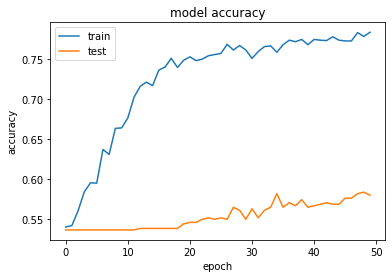

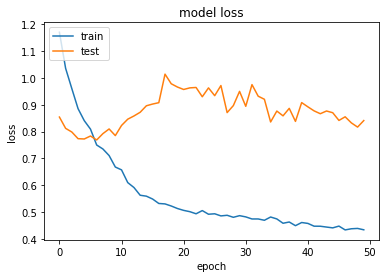

In [51]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 8ms/step


In [49]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 20
batch_size = 3
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)
model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

Epoch 1/20
703/703 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.6946

703/703 [==============================] - 28s 33ms/step - loss: 0.5770 - accuracy: 0.6946 - val_loss: 0.7120 - val_accuracy: 0.6572 - lr: 1.0000e-05
Epoch 2/20
703/703 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.7212

703/703 [==============================] - 22s 31ms/step - loss: 0.5396 - accuracy: 0.7212 - val_loss: 0.5520 - val_accuracy: 0.7595 - lr: 1.0000e-05
Epoch 3/20
464/703 [==================>...........] - ETA: 7s - loss: 0.5270 - accuracy: 0.7234

KeyboardInterrupt: ignored